# Pairing image

In [8]:
import os
import random
import shutil
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import cv2

## Merge train and test set from original dataset

### Paths

In [2]:
# Define paths
real_test_path = r"D:\Sketchy\Sketchy\real_test"
real_train_path = r"D:\Sketchy\Sketchy\real_train"
real_path = r"D:\Sketchy\Sketchy\real"

# Create the real directory if it doesn't exist
os.makedirs(real_path, exist_ok=True)

### Merging

In [3]:
test_subfolders = set(os.listdir(real_test_path))
train_subfolders = set(os.listdir(real_train_path))

# Merge subfolders
all_subfolders = test_subfolders.union(train_subfolders)

for subfolder in all_subfolders:
    # Create subfolder in the real directory
    real_subfolder_path = os.path.join(real_path, subfolder)
    os.makedirs(real_subfolder_path, exist_ok=True)

    # Copy files from real_test to real
    test_subfolder_path = os.path.join(real_test_path, subfolder)
    if os.path.exists(test_subfolder_path):
        for file_name in os.listdir(test_subfolder_path):
            shutil.copy(os.path.join(test_subfolder_path, file_name), real_subfolder_path)

    # Copy files from real_train to real
    train_subfolder_path = os.path.join(real_train_path, subfolder)
    if os.path.exists(train_subfolder_path):
        for file_name in os.listdir(train_subfolder_path):
            shutil.copy(os.path.join(train_subfolder_path, file_name), real_subfolder_path)

print("Merge complete!")


Merge complete!


# Imange processing

Ảnh real hiện tại đang là RGB, cần sang trắng đen để thể hiện tinh thần tranh sketch

Giải thích những vấn đề với ảnh real hiện tại (demo ảnh random nếu chỉ invert grayscale)

demo với edge enhancer và sử dụng weigh scaling để tăng vùng ảnh ( có thẻ cho dùng edge enhancer rồi so sánh output RGB và trắng đen để so sánh hiệu quả weight scaling)

### Randomize set of images

In [10]:
def get_images_by_category(real_path):
    """
    Retrieve all subfolders and images in the given real path.

    Args:
        real_path (str): The root directory containing subfolders with images.

    Returns:
        dict: A dictionary with subfolder names as keys and lists of image file names as values.
    """
    data = {}
    for subfolder in os.listdir(real_path):
        subfolder_path = os.path.join(real_path, subfolder)
        if os.path.isdir(subfolder_path):
            # List all files in the subfolder
            images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
            data[subfolder] = images
    return data

image_data = get_images_by_category(real_path)


def random_image_picker(data):
    """
    Pick a random image from the dictionary.

    Args:
        data (dict): Dictionary containing subfolder names and their images.

    Returns:
        tuple: Subfolder name and randomly selected image file name.
    """
    subfolder = random.choice(list(data.keys()))  # Randomly select a subfolder
    if data[subfolder]:
        image = random.choice(data[subfolder])  # Randomly select an image from the subfolder
        return subfolder, image
    else:
        return subfolder, None

# Example usage
picked_subfolder, picked_image = random_image_picker(image_data)
print(f"Randomly picked image: {picked_image} from category: {picked_subfolder}")


Randomly picked image: n07753592_16139.png from category: banana


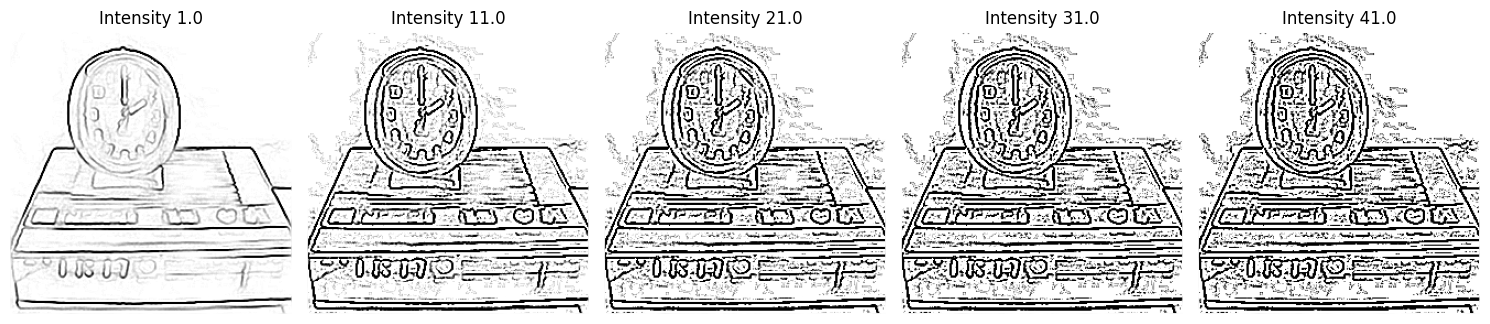

In [7]:
# Load the sketch
image_path = r"D:\Sketchy\Sketchy\real\alarm_clock\n02694662_17579.png"
img = Image.open(image_path)

# Function to enhance edges and emphasize light colors
def enhance_light_edges(image, intensity=1.0, color_weight=(0.3, 0.59, 0.11)):
    """
    Enhance edges and emphasize light-colored edges.
    
    Args:
        image (PIL.Image): Input RGB image.
        intensity (float): Intensity of edge enhancement.
        color_weight (tuple): Weights for RGB channels in greyscale conversion.
    
    Returns:
        PIL.Image: Processed image with enhanced light edges.
    """
    # Apply edge enhancement filter
    edge_enhanced = image.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
    # Blend the original and enhanced images reald on intensity
    enhanced_image = Image.blend(image, edge_enhanced, alpha=intensity)
    
    # Emphasize light-colored edges by converting to greyscale with custom weights
    enhanced_array = np.array(enhanced_image)
    greyscale_array = (
        enhanced_array[:, :, 0] * color_weight[0] +
        enhanced_array[:, :, 1] * color_weight[1] +
        enhanced_array[:, :, 2] * color_weight[2]
    ).astype(np.uint8)
    
    # Invert the greyscale image for better contrast
    inverted_array = 255 - greyscale_array
    enhanced_image = Image.fromarray(inverted_array)
    return enhanced_image

# Visualization parameters
s, e, step = 1, 40, 10  # Start, end, and step for intensity
intensities = np.arange(s, e + step, step)  # Generate intensity range

# Plot results
plt.figure(figsize=(15, 5))

for i, intensity in enumerate(intensities, 1):
    enhanced_img = enhance_light_edges(img, intensity=intensity, color_weight=(0.000, 0.000, 1))
    plt.subplot(1, len(intensities), i)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title(f"Intensity {intensity:.1f}")
    plt.axis("off")


plt.tight_layout()
plt.show()


# GreyScale all real images edges

from PIL import Image
import os

# Define the path to the "real" folder
real_path = r"D:\Sketchy\Sketchy\real"  # Update this if the folder is not in the current directory

# Iterate over all subfolders and files
for root, dirs, files in os.walk(real_path):
    for file in files:
        # Full path to the current file
        file_path = os.path.join(root, file)
        
        try:
            # Open the image
            with Image.open(file_path) as img:
                # Convert the image to grayscale
                grayscale_img = img.convert("L")
                # Save the grayscale image, overwriting the original file
                grayscale_img.save(file_path)
            print(f"Converted: {file_path}")
        except Exception as e:
            print(f"Failed to process {file_path}: {e}")

print("All images have been converted to grayscale.")
